# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pmdarima as pm
import statsmodels.api as sm
import itertools
from matplotlib import style

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=InterpolationWarning)

In [5]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
plt.style.use('seaborn-v0_8')

# Helper Functions

In [7]:
def compare_item(item_code_1,item_code_2):
    '''This functions shows the descriptive information about the two comparing items.'''
    
    for c in o_col:
        if c not in ['PER_TAG','date']:
            print(c+':\t\t',df[df['ITEM_CODE']==item_code_1][c].unique(),df[df['ITEM_CODE']==item_code_2][c].unique())
            

In [8]:
def plot_timeseries(item,date,retailer):
    '''Plots trendline for given item and mentioned retailer.'''
    
    y=df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)]['VOLUME'].values
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y,'o-',color='green')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume across the time',fontsize=20)
    plt.show()

In [9]:
def plot_corr(segment,retailer,annot=True):
    '''This functions plots the correlation heatmap for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    plt.figure(figsize=(15,12))
    sns.heatmap(dummy.corr(),annot=annot)
    plt.show()
    
def get_corr(df,segment,retailer):
    '''This functions shows the correlation coefficient values for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    
    return dummy.corr()

In [10]:
def get_highest(correlation_dataframe,correlation_value):
    '''This function returns the multi indexed dataframe showing items having highest correlation value'''
    
    New=pd.DataFrame()
    if correlation_dataframe.shape[1]>1:
        for col in correlation_dataframe.columns:
            item_1=[col]*correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].shape[0]
            item_2=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].index)
            item_1=[int(x) if type(x)==int else str(x) for x in item_1]
            item_2=[int(x) if type(x)==int else str(x) for x in item_2]
            corr=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].values)
            T=pd.DataFrame({'Item_1':item_1,
                           'Item_2':item_2,
                           'Corr':corr})
            T['Corr']=T['Corr'].apply(lambda x:x[0])
            New=pd.concat([New,T],ignore_index=True)
    else:
        T=pd.DataFrame({'Item_1':correlation_dataframe.index,
                           'Item_2':correlation_dataframe.columns,
                           'Corr':correlation_dataframe.iloc[0,0]})
        #T['Corr']=T['Corr'].apply(lambda x:x[0])
        New=pd.concat([New,T],ignore_index=True)
    
    New.set_index(["Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return New

In [11]:
def segment_wise_correlation(dataframe,retailer,corr_value):
    '''This functions returns the multi indexed dataframe containing items with high correlation value for 
    all the segments of a dataframe.'''
    
    
    T=pd.DataFrame()
    for seg in dataframe[dataframe['RETAILER']==retailer]['SEGMENT'].unique():
        New=get_highest(get_corr(seg,retailer),corr_value)
        New.reset_index(inplace=True)
        New['SEGMENT']=[seg]*New.shape[0]
        T=pd.concat([T,New],ignore_index=True)
    T.set_index(["SEGMENT","Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return T

In [12]:
def correlated_items_dataframe(df,item,segment,retailer,corr_value):
    '''This function returns dataframe containing Volume Sales of given correlated items.'''
    
    item_list=[int(x) for x in get_highest(get_corr(df,segment,retailer),corr_value).loc[item,:].index]
    N=pd.DataFrame()
    T=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
    T.reset_index(inplace=True,drop=True)
    T=T.rename(columns={T.columns[0]: item})
    if len(item_list)>1:
        for item in item_list:
            N=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
            N.reset_index(inplace=True,drop=True)
            N=N.rename(columns={N.columns[0]: item})
            T=pd.concat([T,N],axis=1)
    T.set_index(df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['date'].values,inplace=True)
    
    return T

In [13]:
def plot_correlated_trendlines(T,date):
    '''This function plots trendlines of given correlated items.'''
    
    item2_list=[int(col) for col in T.columns[1:-3]]
    y1=T[T.columns[0]]
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y1,'o-')
    leg=[T.columns[0]]
    
    for y in item2_list:
        ax.plot(x,T[[y]].values,'o-')
        leg.append(y)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume Trend across Time ',fontsize=20)
    plt.legend(leg)
    plt.show()

In [14]:
def plot_correlated_trendlines_separately(dataframe):
    '''This function plots trendlines of highly correlated items separately.'''
    
    fig, axes = plt.subplots(nrows=dataframe.shape[1], ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        y=dataframe[dataframe.columns[i]]
        x=date
        if i==0:
            ax.plot(x,y,'.-',color='red' ,linewidth=0.4)
        else:
            ax.plot(x,y,'.-' ,linewidth=0.4)
        ax.set_title(dataframe.columns[i])
        plt.xticks(rotation=90,fontsize=14)
        #plt.xlabel('Dates',fontsize=20)
        plt.yticks(rotation=0,fontsize=14)
        #plt.ylabel(str(item),fontsize=14)
        ax.xaxis_date()     # interpret the x-axis values as dates
        fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
        #plt.grid(True)
        #plt.title('Volume Sales for {}'.format(item),fontsize=20)
        #ax.xaxis.set_ticks_position(None)
        #ax.yaxis.set_ticks_position(None)
        #ax.spines['Top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

In [15]:
def ADF_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series contains a unit root, it is not stationary.
       Alternative Hypothesis: There is no unit root.
       
       Low p-values are preferable. If the test returns a p-value BELOW the chosen significance level (e.g.0.05),
       we reject the null and conclude that the series does not contain a unit root.It appears to be stationary.
       '''
    adf_test = adfuller(x, autolag="aic")
    t_stat, p_value, _, _, _, _  = adf_test
    conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
    res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
    return res_dict

In [16]:
def KPSS_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series is stationary around a deterministic trend (trend-stationary)
       Alternative Hypothesis: The series has a unit root. It is non-stationary.
       
       High p-values are preferable. If the test returns a p-value ABOVE the chosen significance level (e.g.0.05),
       we conclude that the series appears to be atleast trend stationary.
       
    '''
    kpss_test = kpss(x)
    t_stat, p_value, _, critical_values  = kpss_test
    conclusion = "stationary" if p_value > ALPHA else "not stationary"
    res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
    return res_dict

In [17]:
def plot_stationarity(time_series, lags,model):
    
    y=time_series
    # decompose the time series into trend, seasonality and residuals
    decomp = seasonal_decompose(time_series, 
                                   model=model, 
                                   period=lags)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))
    y.plot(ax=ax1)
    #ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title(y.name)
    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")
    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);
    plt.tight_layout()

In [18]:
def get_segment(df,segment,retailer,date):
    item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()[0]
    T=correlated_items_dataframe(df,item,segment,retailer,0)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [19]:
def get_items_from_segment(item,segment,retailer,date,corr_value=0.8):
    T=correlated_items_dataframe(item,segment,retailer,corr_value)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    #T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [20]:
def plot_timeseries_segment(dataframe,segment):
    x=get_dates(dataframe)
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,dataframe[segment].values,'o-',color='blue',linewidth=2.15)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('{} volume across the time'.format(segment),fontsize=20)
    plt.show()

In [21]:
def get_dates(dataframe):
    date=dataframe
    date.reset_index(inplace=True,drop=True)
    date=pd.to_datetime(date['date'])
    return date

In [22]:
def check_stationarity(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns[:-3]:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

In [23]:
def check_stationarity2(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    
    
    return N

In [24]:
def sarimax_gridsearch(ts, pdq, pdqs):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs)
                output = mod.fit() 
            except:
                print('pass')
                continue
            
            
            forecast=output.predict(start=0,end=109)
            ans.append([comb, combs, output.bic,MAPE(train.flatten(),forecast)])
            print('SARIMAX {} x {} : BIC Calculated ={}, MAPE Calculated= {}'.format(comb, combs, output.bic,MAPE(train.flatten(),forecast)))
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic','mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)[0:5]
    
    return ans_df

In [25]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def WAPE(y_true, y_pred, weighting = 'non-zero-flag'):
    w = {'non-zero-flag':np.where(y_true == 0, 0, 1), 
         'y':y_true,
        }.get(weighting)
    return mean_absolute_percentage_error(y_true, y_pred, w)

def TAPE(y_true, y_pred):
    total = np.sum(np.abs(y_true))
    pe = (y_pred - y_true)/total
    return np.sum(np.abs(pe)) if total > 0 else np.inf

def adj_PE(y_true, y_pred):
    return (y_pred - y_true)/(y_true + 1)

def PE(y_true, y_pred):
    return y_pred/y_true - 1

# Reading & Cleaning data

In [26]:
df=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\DF_dataframe_final.csv')


##### Creating a dictionary containing description about the particular item

In [27]:
item_detail={}
for man in df['MANUFACTURER'].unique():
    for item in df[df['MANUFACTURER']==man]['ITEM_CODE'].unique():
        item_detail[item]=df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique()
        #print(item,df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique())

##### Creating a list containing names for all the object type columns

In [28]:
o_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='O':
        o_col.append(c)

##### Creating a list containing names for all the integer type columns

In [29]:
i_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='int':
        i_col.append(c)

##### Creating a list containing names for all the float type columns

In [30]:
f_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='float':
        f_col.append(c)

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [31]:
rem_f_col=[]
for i in f_col[:-117]:
    if df[i].describe()['std']==0 and df[i].describe()['mean']==0:
        rem_f_col.append(i)
        

##### Creating a list containing names for all the columns which contains SINE values       

In [32]:
sine_col=f_col[-117:]

##### Removing all the selected columns

In [33]:
f_col=[ele for ele in f_col if ele not in rem_f_col+sine_col]

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [34]:
zero_col=[]
for col in f_col:
    if df.shape[0]*0.95<=df[df[col]==0].shape[0]:
        zero_col.append(col)
        #print(col,df[df[col]==0].shape[0])

##### Removing all the selected columns

In [35]:
f_col=[ele for ele in f_col if ele not in zero_col]

In [36]:
o_col=[ele for ele in o_col if ele not in ['WEEK_END_DATE', 'WEEK_END_DATE_New']]

##### Date Timeline

In [37]:
date=get_dates(df[(df['ITEM_CODE']==9300701525033)&(df['RETAILER']=='Woolworths')][['date']])

--------

# Dealing only with ONGOING SKUs:
- Reading files
    - **orders**: This dataframe contains the model orders for already trained SKUs, we use this dataset to use the parameters from  last trained model.
    - **ongoing**: This dataframe contains the description of the ongoing items only.
- Converting and extracting the dataset of ongoing items.
- For the item in ongoing we then extract model parameters from order dataframe.
- Initialising the values for model parameters.
- Generating predictions, forecast and errors for fitted model.
    - ARIMA
    - SARIMA
    - ARIMA_capped (Upper Limit )
    - SARIMA_capped (Upper Limit )

**Reading Files**

In [40]:
orders=pd.read_excel(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\Predictions\Errors_CSV\ErrorMetrics.xls',
                    sheet_name='ARIMA, SARIMA Results',header=0,
                    usecols=['ITEM_CODE', 'SEGMENT', 'RETAILER', 'ARIMA','SARIMA','ARIMA Capped',
                            'SARIMA Capped'])


In [41]:
ongoing=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\EDA\Classified TimeSeries\Ongoing.csv',index_col='Unnamed: 0')

**Converting and extracting the dataset of ongoing items.**

In [42]:
D=pd.DataFrame()
for i in ongoing.index:
    D=pd.concat([D,df[(df['ITEM_CODE']==ongoing['ITEM'].loc[i])&(df['RETAILER']==ongoing['RETAILER'].loc[i])]],
                axis=0,ignore_index=False)
                 

In [43]:
df1=D.copy()

**For the item in ongoing we then extract model parameters from order dataframe.**

In [44]:
def get_description(ongoing,i):
    item=int(ongoing['ITEM'].loc[i])
    segment=ongoing['SEGMENT'].loc[i]
    retailer=ongoing['RETAILER'].loc[i]
    
    return item,segment,retailer

------
## Generating Forecast for Given SKU

- Prediction for item at 0th position.

In [45]:
ongoing.head()

,RETAILER,SEGMENT,ITEM,STATUS
0,Woolworths,Other Car,12844067194,Ongoing
1,Woolworths,Other Car,12844082043,Ongoing
4,Woolworths,Other Car,12844090314,Ongoing
5,Woolworths,Other Car,12844090321,Ongoing
7,Woolworths,Other Car,12844092035,Ongoing


In [46]:
i=0 # Index of SKU in ongoing dataset
item,segment,retailer=get_description(ongoing,i)

In [47]:
segment_dataframe=get_segment(df1,segment,retailer,date)

In [48]:
segment_dataframe.head().T

,2019-04-07,2019-04-14,2019-04-21,2019-04-28,2019-05-05
12844067194,20732.000,18034.000,18105.000,17821.000,17040.000
12844082043,42720.000,39360.000,40800.000,47040.000,32640.000
12844090314,336.000,304.000,306.000,324.000,2734.000
12844090321,432.000,420.000,386.000,442.000,3106.000
12844092035,79395.000,84372.000,79158.000,81765.000,74181.000
12844095937,759.000,248.000,244.000,170.000,186.000
76171101006,6495.000,6077.000,5551.000,6036.000,6670.000
76171178558,3804.000,1560.000,1400.000,1540.000,1412.000
76171520319,974.000,1025.000,973.000,2195.000,1805.000
9311412400014,5689.000,5788.000,5249.000,2855.000,2063.000


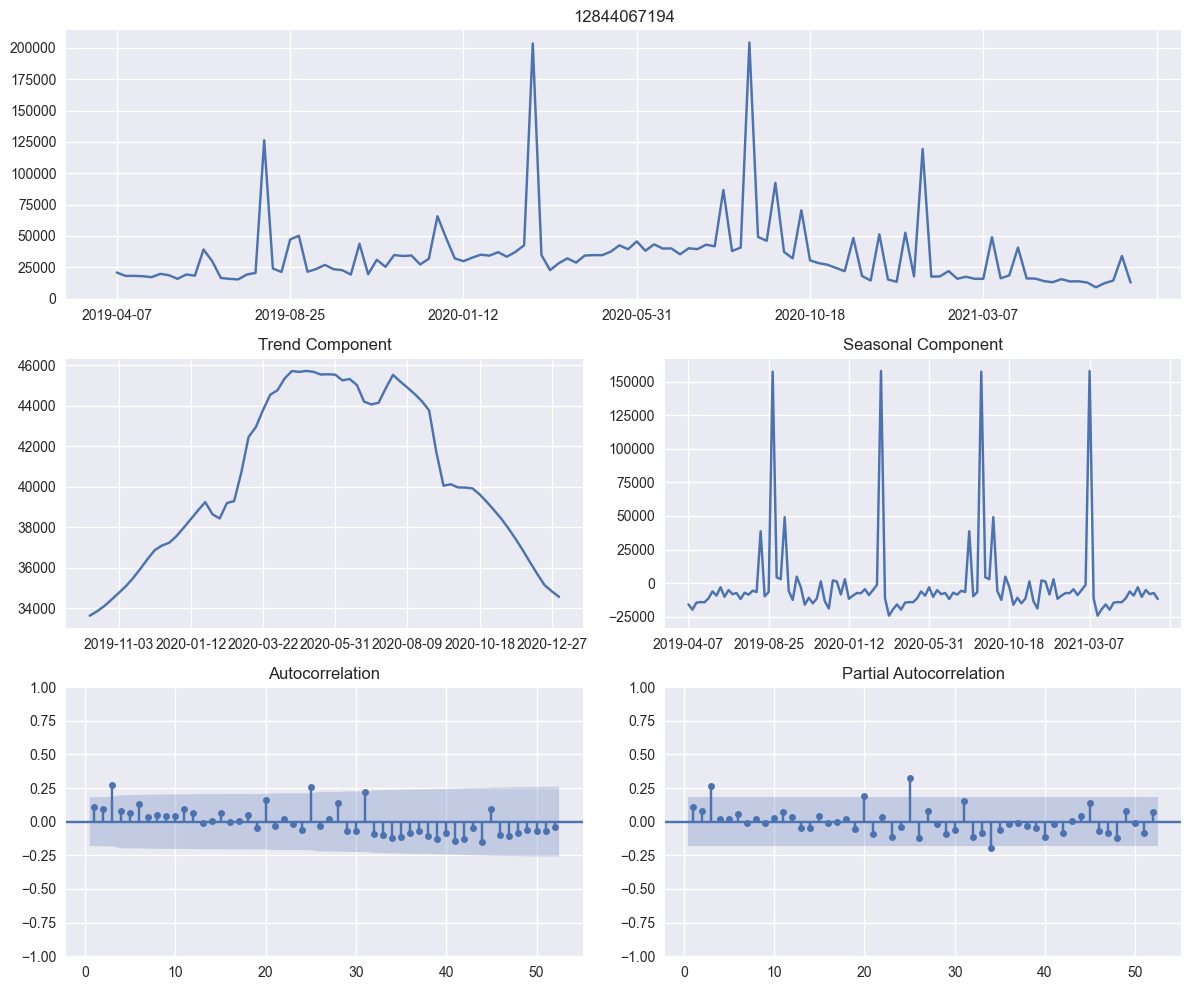

In [49]:
plot_stationarity(segment_dataframe[item],52,'additive')

In [50]:
orders[(orders['ITEM_CODE']==item)&(orders['RETAILER']==retailer)&(orders['SEGMENT']==segment)]

,ITEM_CODE,SEGMENT,RETAILER,ARIMA,SARIMA,ARIMA Capped,SARIMA Capped
0,12844067194.000,Other Car,Woolworths,"(0, 0, 0)","[(1, 0, 1), (0, 0, 1, 12)]","(0, 1, 1)","[(1, 0, 1), (1, 0, 0, 4)]"


In [51]:
#Obtaining index of SKU from order dataset, to extract the parameters for the given SKU
i=orders[(orders['RETAILER']==ongoing['RETAILER'].loc[i])&(orders['ITEM_CODE']==ongoing['ITEM'].loc[i])].index
print(i)

Index([0], dtype='int64')


**Initialising the values for model parameters**

In [52]:
# Extracting the parameters for fitting the model from order dataset
segment=orders['SEGMENT'].iloc[i].values[0]
retailer=orders['RETAILER'].iloc[i].values[0]
arima=orders['ARIMA'].iloc[i].values[0]
sarima=orders['SARIMA'].iloc[i].values[0]
arima_capped=orders['ARIMA Capped'].iloc[i].values[0]
sarima_capped=orders['SARIMA Capped'].iloc[i].values[0]
segment_dataframe=get_segment(df1,segment,retailer,date)
print(f"Segment: {segment}\nRetailer: {retailer}\nARIMA: {arima}\nSARIMA: {sarima}\nARIMA_capped: {arima_capped}\nSARIMA_capped: {sarima_capped}")

Segment: Other Car
Retailer: Woolworths
ARIMA: (0, 0, 0)
SARIMA: [(1, 0, 1), (0, 0, 1, 12)]
ARIMA_capped: (0, 1, 1)
SARIMA_capped: [(1, 0, 1), (1, 0, 0, 4)]


In [53]:
# Cleaning the extracted the features
sarima=[x.strip('( )') for x in sarima.strip('),(').strip('[]').split('),')]
arima=[int(x) for x in arima.strip(']()[').split(',')]
sarima_capped=[x.strip('( )') for x in sarima_capped.strip('),(').strip('[]').split('),')]
arima_capped=[int(x) for x in arima_capped.strip(']()[').split(',')]
print(f"Segment: {segment}\nRetailer: {retailer}\nARIMA: {arima}\nSARIMA: {sarima}\nARIMA_capped: {arima_capped}\nSARIMA_capped: {sarima_capped}")

Segment: Other Car
Retailer: Woolworths
ARIMA: [0, 0, 0]
SARIMA: ['1, 0, 1', '0, 0, 1, 12']
ARIMA_capped: [0, 1, 1]
SARIMA_capped: ['1, 0, 1', '1, 0, 0, 4']


-----
# Model Fitting

In [54]:
item=int(orders['ITEM_CODE'].iloc[i])

In [55]:
item_sales=segment_dataframe[[item]]

### Create Training and Test

In [56]:
train = item_sales.values[:-8]
test = item_sales.values[-8:]

In [57]:
# Initialising dictionary to store the results
description={}
description['ITEM']=item
description['SEGMENT']=segment
description['RETAILER']=retailer

-----
# ARIMA

In [58]:
p,d,q=arima[0],arima[1],arima[2]
p,d,q

(0, 0, 0)

### Model Fitting

In [60]:
model=sm.tsa.arima.ARIMA(train,order=(p,d,q))
results=model.fit()

In [61]:
description['ARIMA']=[(p,d,q)]

### Forecasting Time Series

In [62]:
forecast=results.predict(start=110,end=117)

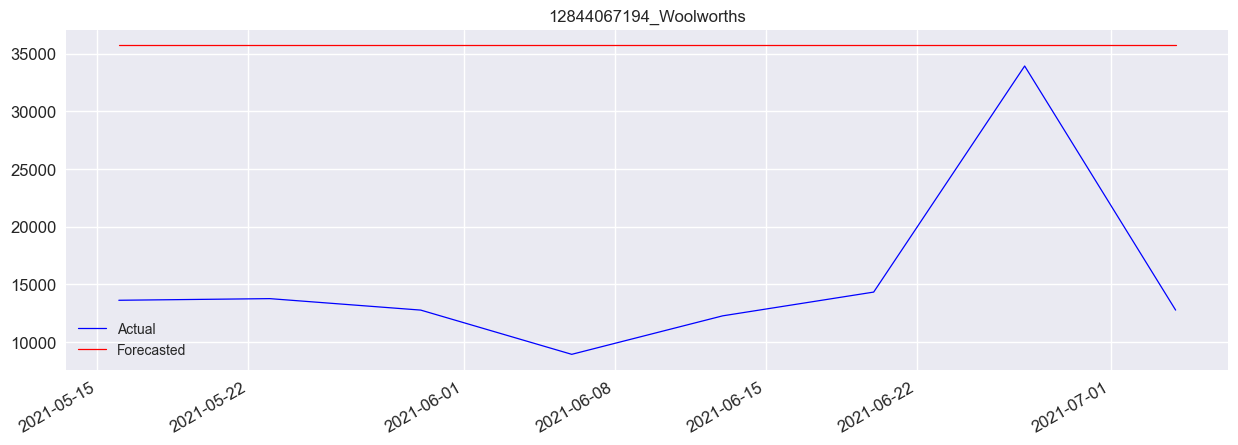

In [63]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("{}_{}".format(item,retailer))
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='lower left')
plt.show()

### Durbin Watson Test for Autocorrelation among residuals

In [64]:
out = durbin_watson(results.resid)
description['Autocorrelation_ARIMA']=out
print("Autocorrelation among residual for {}".format(item_sales.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 1.83


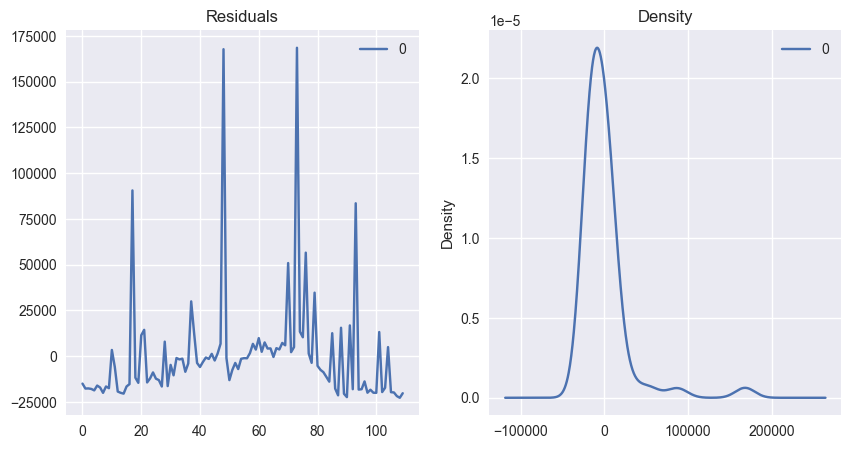

In [65]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(10,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Error Metrics

In [66]:
description['MAPE_ARIMA']=MAPE(test.flatten(),forecast)
description['WAPE_ARIMA']=WAPE(test.flatten(),forecast)*100
description['TAPE_ARIMA']=TAPE(test.flatten(),forecast)*100
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))
print("For SKU: {} WAPE is : {}".format(item,WAPE(test.flatten(),forecast)*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(test.flatten(),forecast)*100))

For SKU: 12844067194 MAPE is : 165.73019948030657
For SKU: 12844067194 WAPE is : 165.73019948030657
For SKU: 12844067194 TAPE is : 133.43978919631095


In [67]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['RMSE_ARIMA']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 35738.17.
Root Mean Squared Error is :21662.95


-----
# SARIMA

In [68]:
sarima[0]=[int(i) for i in sarima[0].split(',')]
sarima[1]=[int(i) for i in sarima[1].split(',')]

In [69]:
sarima[0][0]

1

In [70]:
p,d,q=sarima[0][0],sarima[0][1],sarima[0][2]
ps,ds,qs,ss=sarima[1][0],sarima[1][1],sarima[1][2],sarima[1][3]

### Model Fitting

In [71]:
model=sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(ps,ds,qs,ss))
results=model.fit()

In [72]:
description['SARIMA']=[model.order,model.seasonal_order]

### Forecasting Time Series

In [73]:
forecast=results.predict(start=110,end=117)

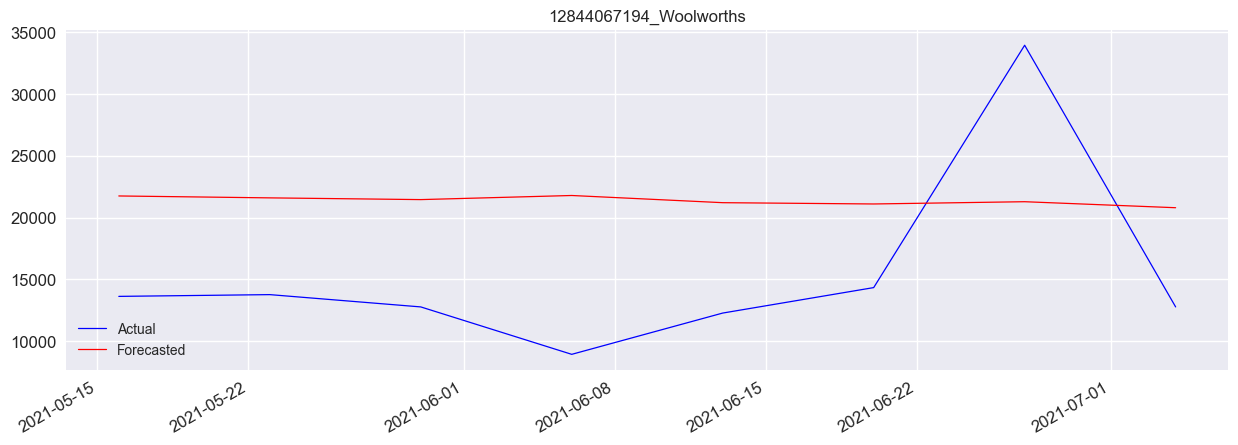

In [74]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("{}_{}".format(item,retailer))
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='lower left')
plt.show()

### Durbin Watson Test for Autocorrelation among residuals

In [75]:
out = durbin_watson(results.resid)
description['Autocorrelation_SARIMA']=out
print("Autocorrelation among residual for {}".format(item_sales.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.05


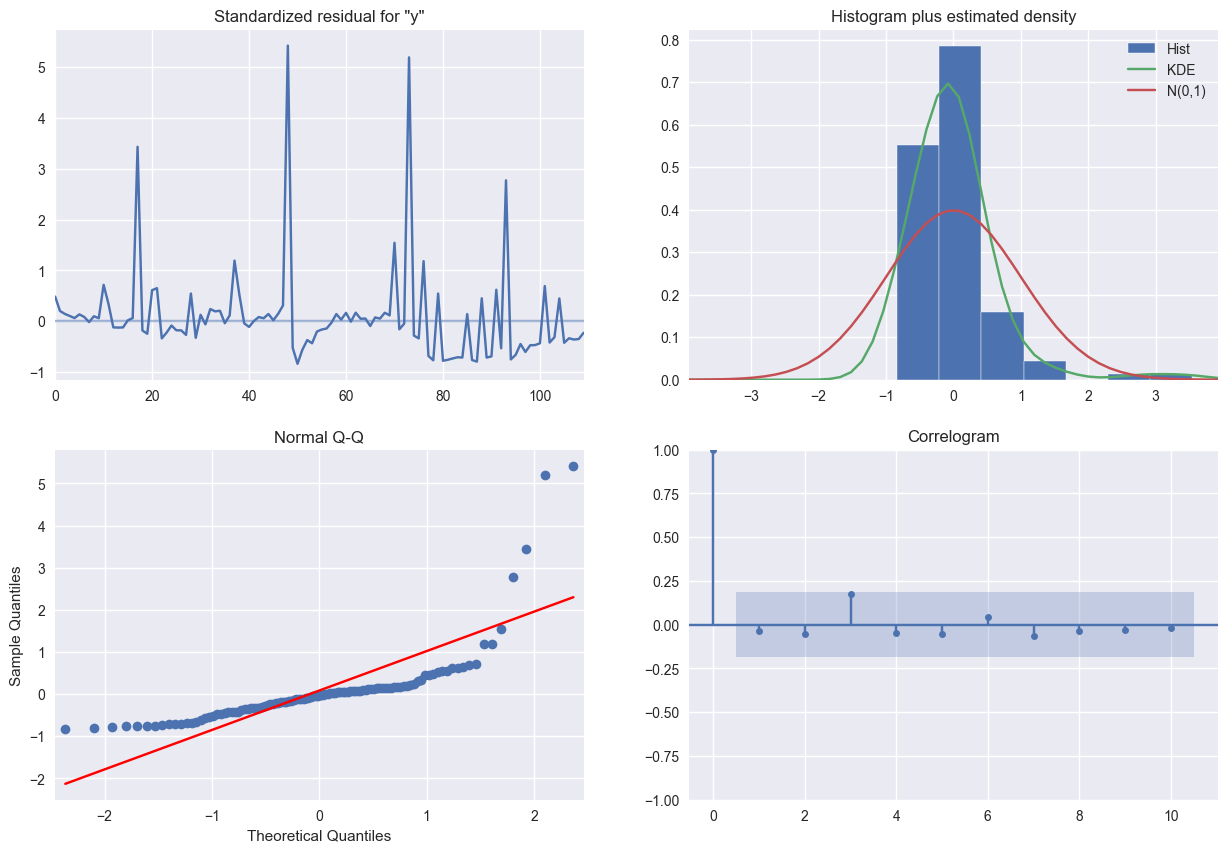

In [76]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

### Error Metrics

In [77]:
description['MAPE_SARIMA']=MAPE(test.flatten(),forecast)
description['WAPE_SARIMA']=WAPE(test.flatten(),forecast)*100
description['TAPE_SARIMA']=TAPE(test.flatten(),forecast)*100
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))
print("For SKU: {} WAPE is : {}".format(item,WAPE(test.flatten(),forecast)*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(test.flatten(),forecast)*100))

For SKU: 12844067194 MAPE is : 68.45744385807646
For SKU: 12844067194 WAPE is : 68.45744385807646
For SKU: 12844067194 TAPE is : 60.27450395882964


In [78]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['RMSE_SARIMA']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 35738.17.
Root Mean Squared Error is :9467.88


--------
# Capping the outliers to upper IQR and Creating model

In [79]:
def get_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    outliers=df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))][[df.columns[0]]].dropna().values.flatten()
    return outliers

In [80]:
def cap_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    upper_limit=Q3+1.5*IQR
    df['Capped Data']=df[df.columns[0]].apply(lambda x:upper_limit.values[0] if x>=upper_limit.values[0] else x)
    return df

In [81]:
item_data=cap_outlier(item_sales)

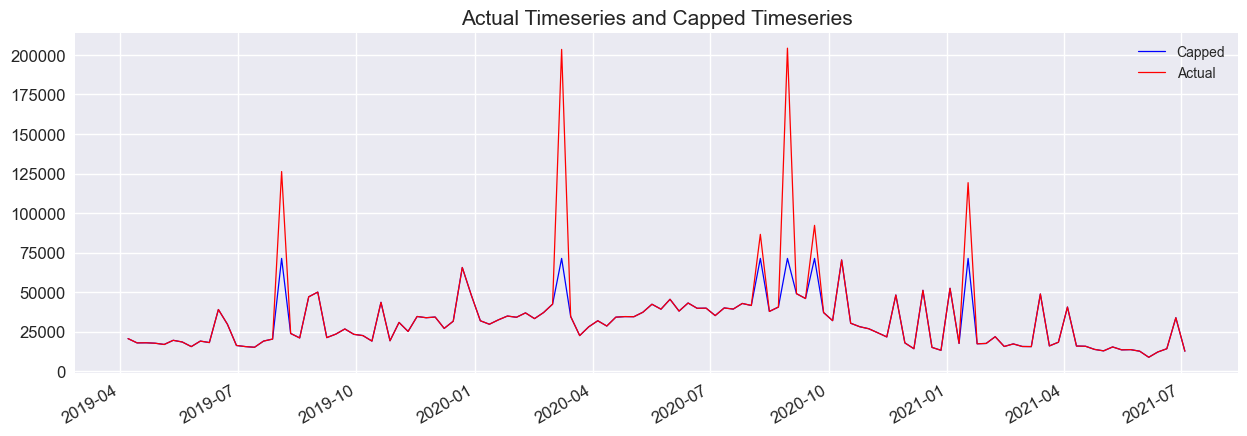

In [82]:
y1=item_data[item_data.columns[1]]
y0=item_data[item_data.columns[0]]
x=date
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("Actual Timeseries and Capped Timeseries",fontsize=15)
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Capped','Actual'])
plt.show()

#### Create Training and Test

In [83]:
train = item_data[[item_data.columns[1]]].values[:-8]
test = item_data[[item_data.columns[1]]].values[-8:]

# ARIMA

### Model Fitting
----

In [84]:
p,d,q=arima_capped[0],arima_capped[1],arima_capped[2]

In [85]:
model=sm.tsa.statespace.SARIMAX(train,order=(p,d, q),seasonal_order=(0,0,0,0))
results=model.fit()


In [86]:
description['ARIMA_capped']=model.order

### Forecasting Time Series

In [87]:
forecast=results.predict(start=110,end=117)

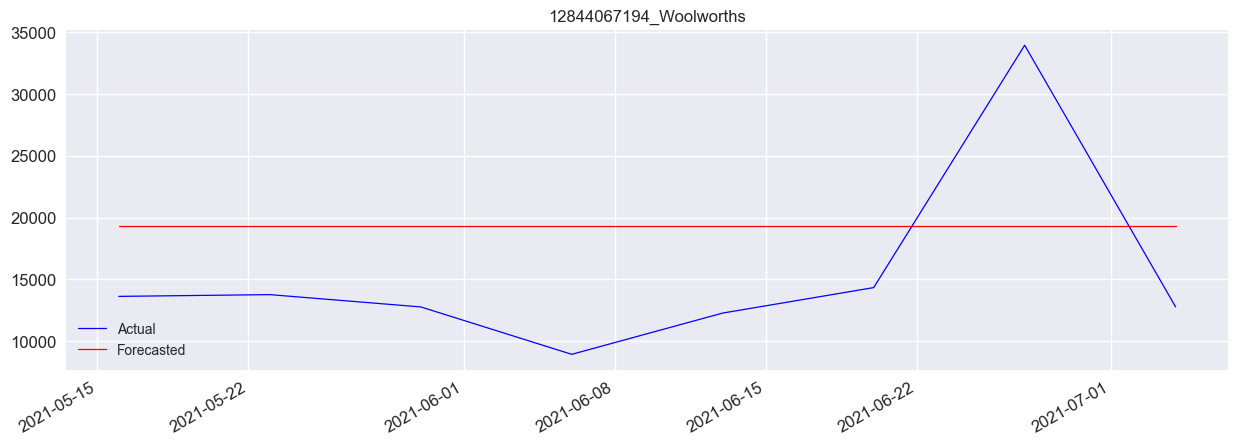

In [88]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("{}_{}".format(item,retailer))
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='lower left')
plt.show()

### Durbin Watson Test for Autocorrelation among residuals

In [90]:
out = durbin_watson(results.resid)
description['Autocorrelation_ARIMA_capped']=out
print("Autocorrelation among residual for {}".format(item_sales.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.09


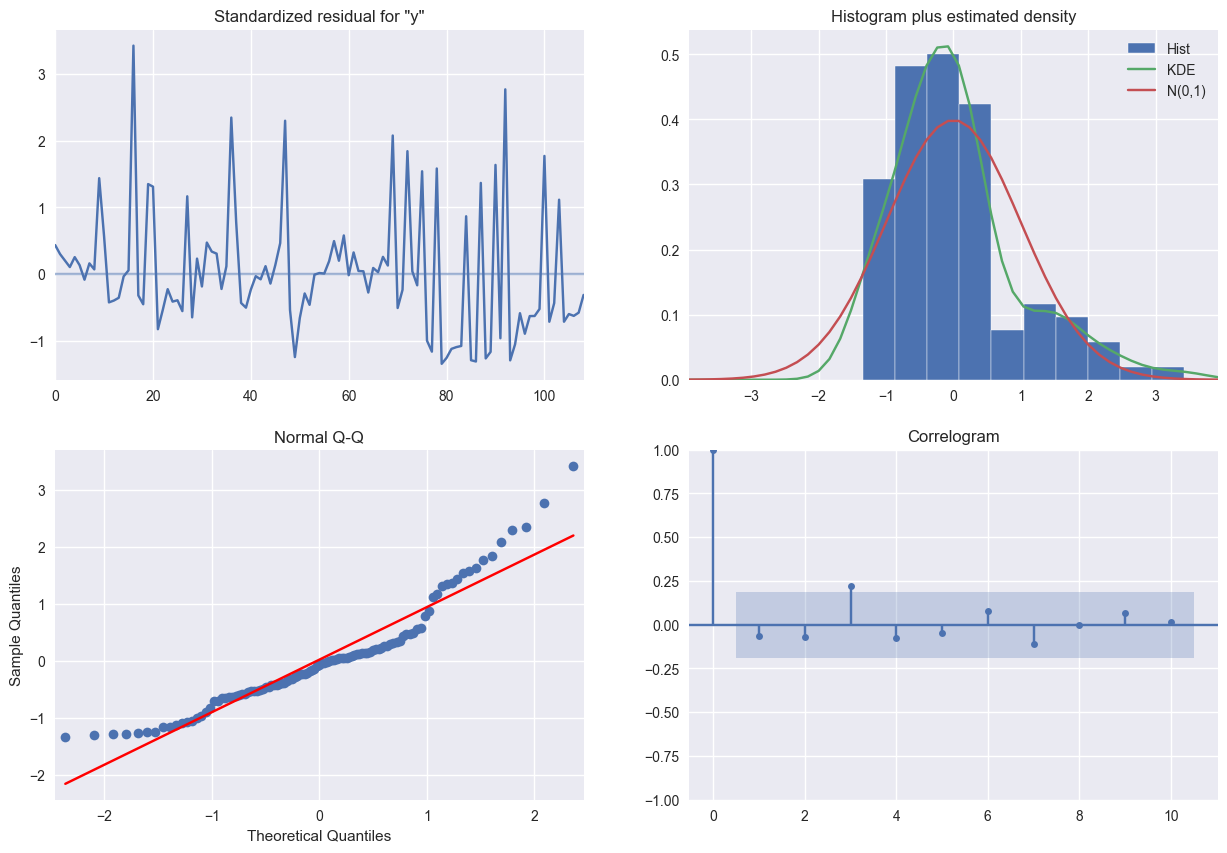

In [91]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

### Error Metrics

In [92]:
description['ARIMA_capped_MAPE']=MAPE(test.flatten(),forecast)
description['ARIMA_capped_WAPE']=WAPE(test.flatten(),forecast)*100
description['ARIMA_capped_TAPE']=TAPE(test.flatten(),forecast)*100
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))
print("For SKU: {} WAPE is : {}".format(item,WAPE(test.flatten(),forecast)*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(test.flatten(),forecast)*100))

For SKU: 12844067194 MAPE is : 54.55426514340764
For SKU: 12844067194 WAPE is : 54.55426514340764
For SKU: 12844067194 TAPE is : 50.16527499395951


In [93]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['ARIMA_capped_RMSE']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 32067.63.
Root Mean Squared Error is :8257.84


-----
# SARIMAX 

In [94]:
sarima_capped[0]=[int(i) for i in sarima_capped[0].split(',')]
sarima_capped[1]=[int(i) for i in sarima_capped[1].split(',')]

In [95]:
p,d,q=sarima_capped[0][0],sarima_capped[0][1],sarima_capped[0][2]
ps,ds,qs,ss=sarima_capped[1][0],sarima_capped[1][1],sarima_capped[1][2],sarima_capped[1][3]

### Model Fitting

In [96]:
model=sm.tsa.statespace.SARIMAX(train,order=(p,d, q),seasonal_order=(ps,ds,qs,ss))
results=model.fit()
description['SARIMA_capped']=[model.order,model.seasonal_order]

### Forecasting Time Series

In [97]:
forecast=results.predict(start=110,end=117)

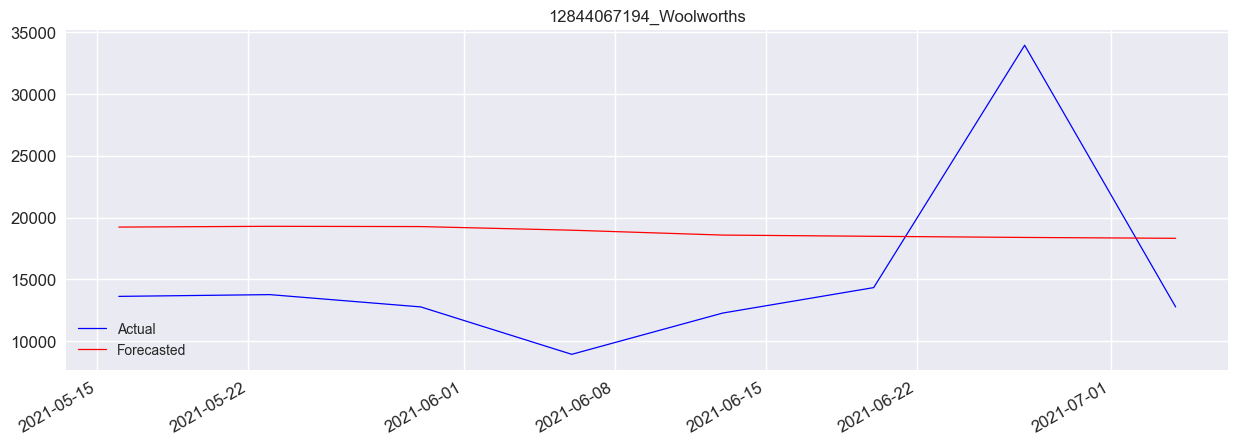

In [98]:
y1=test.flatten()
y0=forecast
x=date[-8:]
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
ax.plot(x,y1,'-',color='blue' ,linewidth=0.9)
ax.plot(x,y0,'-',color='red' ,linewidth=0.9)
ax.set_title("{}_{}".format(item,retailer))
ax.xaxis_date()     # interpret the x-axis values as dates
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
ax.tick_params(labelsize=12)
ax.legend(['Actual','Forecasted'],loc='lower left')
plt.show()

### Durbin Watson Test for Autocorrelation among residuals

In [99]:
out = durbin_watson(results.resid)
description['Autocorrelation_SARIMA_capped']=out
print("Autocorrelation among residual for {}".format(item_sales.columns[0]), ':', round(out, 2))

Autocorrelation among residual for 12844067194 : 2.1


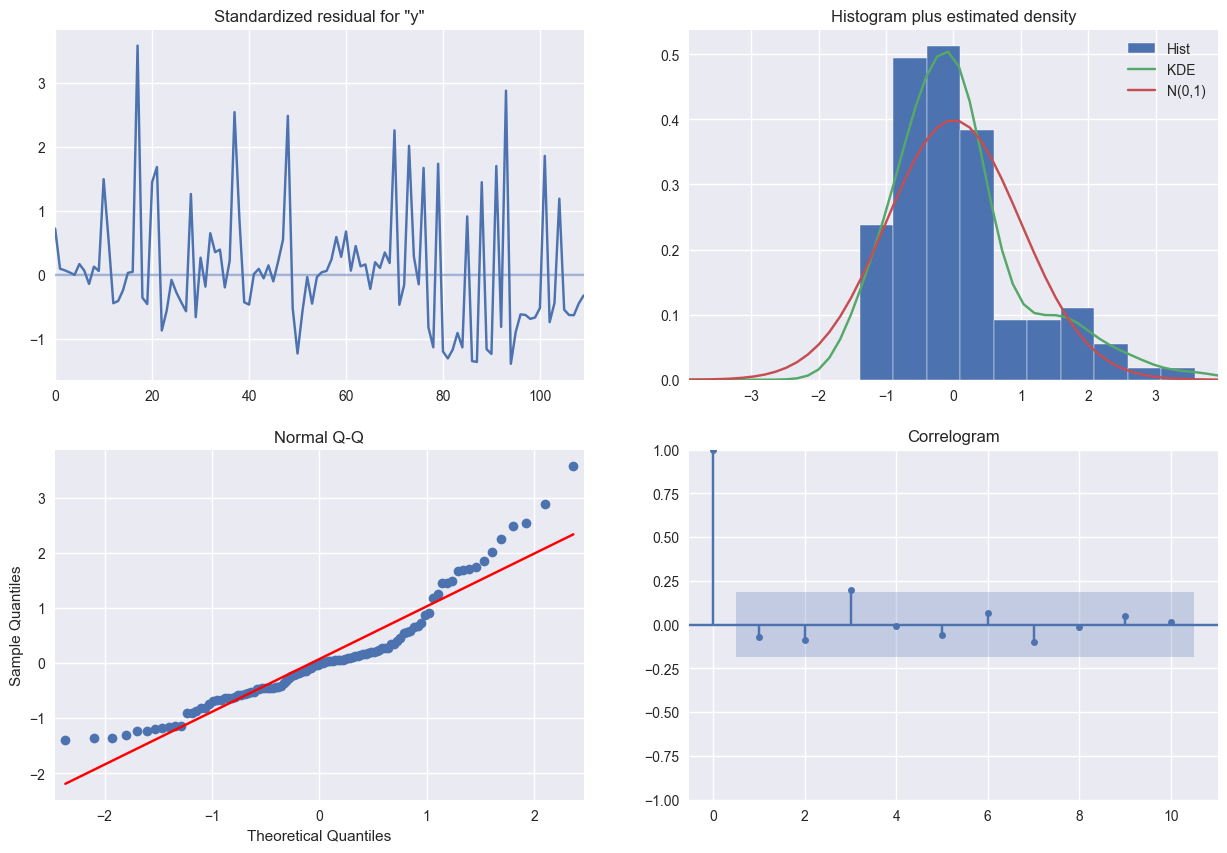

In [100]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

### Error Metrics

In [101]:
description['SARIMA_capped_MAPE']=MAPE(test.flatten(),forecast)
description['SARIMA_capped_WAPE']=WAPE(test.flatten(),forecast)*100
description['SARIMA_capped_TAPE']=TAPE(test.flatten(),forecast)*100
print("For SKU: {} MAPE is : {}".format(item,MAPE(test.flatten(),forecast)))
print("For SKU: {} WAPE is : {}".format(item,WAPE(test.flatten(),forecast)*100))
print("For SKU: {} TAPE is : {}".format(item,TAPE(test.flatten(),forecast)*100))

For SKU: 12844067194 MAPE is : 51.7090539082649
For SKU: 12844067194 WAPE is : 51.7090539082649
For SKU: 12844067194 TAPE is : 48.33622606083674


In [102]:
rmse_item1=math.sqrt(mean_squared_error(test,forecast))
description['SARIMA_capped_RMSE']=rmse_item1
print('Mean Volume Sales for SKU No. {} is : {}.\nRoot Mean Squared Error is :{}'.format(item,round(np.mean(train),2),round(rmse_item1,2)))

Mean Volume Sales for SKU No. 12844067194 is : 32067.63.
Root Mean Squared Error is :8170.65


-------

***To save the results in csv, execute the below markdown code.***

In [ ]:
# description

In [38]:
# from csv import DictWriter
# ##list of column names 
# field_names = [key for key in description.keys()]
# with open('All_Errors.csv', 'a') as f_object:
#     dictwriter_object = DictWriter(f_object, fieldnames=field_names)
#     dictwriter_object.writerow(description)
#     f_object.close()